# Ансамбли моделей. Бэггинг
На одном из прошлых занятий мы познакомились с моделью случайного леса. Вспомним, случайный лес состоит из нескольких моделей деревьев, результаты которых объединяются.

Но если мы можем объединять результаты деревьев, то почему бы не попробовать это с другими моделями, взять несколько моделей, возможно простых, и объединить их. Получим новую модель, которая может быть гораздо лучше чем отдельно взятая из объединяемых моделей. Объединение моделей называют **ансамблем** (ensemble). Построение ансамблей это очень мощный метод машинного обучения, который дает хорошие результаты, а многие применяемые на практике модели являются на самом деле ансамблями моделей. К слову, случайный лес это ансамбль деревьев, теперь ясно, почему он находится в модуле `ensemble` библиотеки `sklearn`.

В зависимости от того как строить и объединять модели в ансамбль можно выделить следующие способы:
* **"Беггинг"** (Bagging, сокращение от  Bootstrap Aggregation, русского краткого названия не придумано, поэтому будем пользоваться английской транскрипцией) - модели обучаются независимо друг от друга, а потом их результаты объединяются, например с помощью голосования по большинству (для классификации) или усреднением (для регрессии). При обучении моделей, чтобы они не оказались совсем одинаковые, каждую модель обучают не на всем, а на подмножестве данных, случайно выбранном из общего набора данных, случайный выбор происходит равномерно с повторениями (bootstrap), т.е. каждый пример из набора данных отбирается равновероятно и может оказаться в одном или нескольких из таких подмножеств. Иногда не только примеры из набора данных, но и признаки (атрибуты) выбираются случайно, как, например, в случайном лесе.
* **"Бустинг"** (Boosting) - модели обучаются последовательно, каждая следующая пытается скомпенсировать ошибки предыдущей, а затем результаты всех моделей объединяются.
* **"Стэкинг"** (Stacking) - способ похож на беггинг, модели, обычно разнородные, обучаются независимо друг от друга, а затем на результатах этих моделей обучается другая мета-модель, которая объединяет результаты.  

В ансамбль можно добавлять самые разнообразные модели, множество примеров и реализаций различных способов ансамблирования уже придумано, можно комбинировать разные способы, мы же познакомимся только с некоторыми из них.


# 1. Бэггинг

## Bootstrap
Беггинг основан на методе *бутстрэпа* выбора примеров, который заключается в следующем. Пусть имеется выборка (набор примеров) **Х** размера  **N**. Случайно равномерно возьмем из выборки **N** объектов с повторением. Это означает, что мы будем **N** раз выбирать произвольный объект выборки (считаем, что каждый объект «достается» с одинаковой вероятностью \\(\frac{1}{N}\\) ), причем каждый раз мы выбираем из всех исходных **N** объектов. Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Из-за возвращения среди них окажутся повторы. Обозначим новую выборку через **X_1**. Повторяя процедуру **M** раз, сгенерируем **M** подвыборок **X_1,..., X_M** . Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.
Если нам нужны меньшие подвыборки, то можем выбирать каждый раз не **N**, а меньшее число примеров.

Выбирая с повторениями мы не нарушаем (в идеале) статистические свойства нашей исходной выборки.
![img](https://drive.google.com/uc?id=1K5ZdEDxeYT9XJcDAaPQg6dsMWkeYYbqY)

Давайте посмотрим как такую процедуру реализовать вручную. В дальнейшем соответствующие команды сделают всю работу за нас.

Обратимся к набору данных оттока клиентов в телефонных компаниях
https://github.com/Yorko/mlcourse.ai/blob/master/data/telecom_churn.csv

и посмотрим (команда [`kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) из `seaborn`) на статистику звонков лояльных клиентов и бывших клиентов.

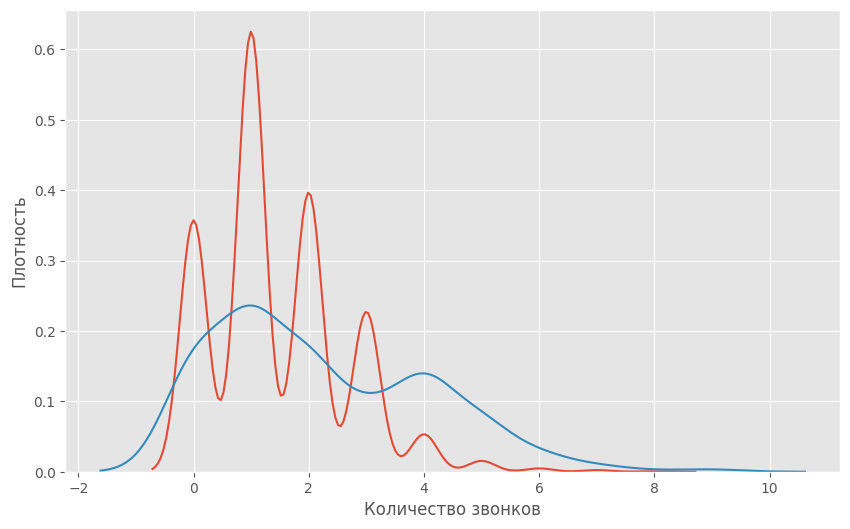

In [ ]:
import pandas as pd #  pandas для работы с таблицами
from matplotlib import pyplot as plt # графики
plt.style.use('ggplot')# стиль графиков
plt.rcParams['figure.figsize'] = 10, 6 # размер окна графиков
import seaborn as sns # для графиков
%matplotlib inline
URL='https://drive.google.com/uc?id=1U9LC5ECI2_Jvq4FrZNCOn3gCT7T5Y5DD'
telecom_data = pd.read_csv(URL) # загружаем данные в таблицу

# выбираем и отображаем звонки (столбец 'Customer service calls') лояльных клиентов (столбец ['Churn'] == False))
fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == False]['Customer service calls'], label = 'Loyal')
# выбираем и отображаем звонки (столбец 'Customer service calls') нелояльных, бывших клиентов (столбец ['Churn'] == True))
fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == True]['Customer service calls'], label = 'Churn')

fig.set(xlabel='Количество звонков', ylabel='Плотность') # подписи осей
plt.show() # отображаем
#https://www.pvsm.ru/python/250970

*Примечание: Это, конечно,  так плавно только отображается, на самом деле число звонков - целое положительное число*

Количество звонков в сервисный центр у лояльных клиентов меньше, чем у бывших клиентов, оно и не удивительно. Теперь оценим сколько в среднем делает звонков каждая из групп. Так как данных в нашем наборе мало, то просто среднее число не очень информативно, оно может изменяться довольно сильно при изменении набора данных, лучше применить бутстрэп. Давайте из нашей исходной выборки сгенерируем 1000 новых подвыборок меньшего размера и сделаем оценку интервального среднего на них. Тем самым мы сами изменяем набор данных и можем оценить как такое изменение влияет на среднее значение, в каких пределах оно может изменяться.  

In [ ]:
import numpy as np #
def get_bootstrap_samples(data, n_samples, n_data):
    # функция для генерации подвыборок с помощью бутстрэпа

    # выбираем случайно n_samples на n_data индексов данных data
    # randint автоматически обеспечивает повторения
    indices = np.random.randint(0, len(data), (n_samples, n_data))
    # отбираем по этим индексам данные
    samples = data[indices]
    return samples # возвращаем

def stat_intervals(stat, alpha):
    # функция для интервальной оценки

    # считаем границы интервала (перцентиля) для заданного процента вероятности alpha
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries #

n_samples=1000;# число подвыборок
n_data=500;# размер подвыборки
# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
loyal_calls = telecom_data[telecom_data['Churn'] == False]['Customer service calls'].values
churn_calls= telecom_data[telecom_data['Churn'] == True]['Customer service calls'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэпа и сразу считаем по каждой из них среднее
loyal_mean_scores = [np.mean(sample)
                       for sample in get_bootstrap_samples(loyal_calls, n_samples, n_data)]
churn_mean_scores = [np.mean(sample)
                       for sample in get_bootstrap_samples(churn_calls, n_samples, n_data)]

#  выводим интервальную оценку среднего
print("Service calls from loyal:  mean interval",  stat_intervals(loyal_mean_scores, 0.05))
print("Service calls from churn:  mean interval",  stat_intervals(churn_mean_scores, 0.05))

# просто среднее
print("Service calls from loyal:  mean ",  np.mean(loyal_calls))
print("Service calls from churn:  mean ",  np.mean(churn_calls))

#https://www.pvsm.ru/python/250970

Service calls from loyal:  mean interval [1.35  1.556]
Service calls from churn:  mean interval [2.06   2.3961]
Service calls from loyal:  mean  1.4498245614035088
Service calls from churn:  mean  2.229813664596273


В итоге мы получили, что с 95% вероятностью среднее число звонков от лояльных клиентов будет лежать в промежутке между 1.35 и 1.55, в то время как наши бывшие клиенты звонили в среднем от 2.06 до 2.39 раз.  Обратите внимание, что интервал для лояльных клиентов уже, что довольно логично, так как они звонят редко (в основном 0, 1 или 2 раза), а недовольные клиенты будут звонить намного чаще, но со временем их терпение закончится, и они поменяют оператора.

Изменяйте число подвыборок и их размер и посмотрите как это влияет на интервал для среднего значения.

Обратите внимание, что вместо одной большой выборки, мы получили много меньших, и можем теперь считать не просто среднее, а обучать модели, результаты которых потом объединить.

Бэггинг позволяет снизить дисперсию (разброс, variance) результатов обучаемых моделей. Это возможно если модели ошибаются независимо друг от друга: одна ошибется в плюс, а другая в минус - в среднем получится то, что надо. Но это же условие является и ограничением беггинга - модели должны быть независимы (статистически) и ошибаться по-разному. Если же все модели имеют общую ошибку, то беггинг никак не поможет.

В библиотеке `sklearn` в модуле `ensemble` есть реализация [`BaggingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) для беггинга в задачах регрессии и [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) для беггинга в задачах классификации которым можно указать аргументы:
* `base_estimator` - объект типа модели в ансамбле (все модели будут одного типа), по умолчанию - дерево.
* `n_estimators` - число моделей в ансамбле, 10 по умолчанию.
* `max_samples` - число или доля примеров в подвыборке моделей, по умолчанию 1.0        
* `max_features` - число или доля признаков в подвыборке моделей, по умолчанию 1.0
* `bootstrap` - использовать ли бутстреп для примеров, по умолчанию да, True
* `bootstrap_features` - использовать ли бутстреп для признаков, по умолчанию нет,False
* `oob_score` - разрешить ли использование примеров не вошедших в подвыборку (oob = out of bag) для оценки ошибки модели, по умолчанию нет, False
* и другие.

Создаваемый объект - классификатор или регрессор - имеет следующие поля:

* `base_estimator_` - тип моделей в ансамбле
* `n_features_` - число признаков после обучения
* `estimators_` - список (list) обученных моделей
* `estimators_samples_` - список подвыборок для обученных моделей
* `estimators_features_` - список признаков для обученных моделей
* `oob_score_` - оценка ошибки модели, если было разрешено

Для регрессоров:

* `oob_prediction_` - массив результатов (выходов) регрессора  для oob примеров. Может быть NaN, если пример был во всех подвыборках (такое может случиться если моделей в ансамбле мало).

Для классификаторов:

* `classes_` - массив меток классов
* `n_classes_` - число классов
* `oob_decision_function_` - массив результатов классификации на oob примерах размера(n_samples, n_classes), может быть NaN, если пример был во всех подвыборках.

В примере ниже создадим ансамбль из деревьев для простой задачи регрессии, для которой ошибку можно разложить на три составляющие:

\\( ошибка=смещение^2+дисперсия+шум \\)
* смещение (bias) - среднее отклонение значения модели от истинного.
* дисперсию - разброс значений моделей от среднего.
* шум (дисперсия шума) - оставшаяся неустранимая часть ошибки.

*(необязательно: если интересно как это сделать математически, смотри, например, здесь: [Дилемма смещения–дисперсии](https://ru.wikipedia.org/wiki/Дилемма_смещения–дисперсии) )*

Посмотрим, как ансамбль влияет на эту ошибку.

Tree         : 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


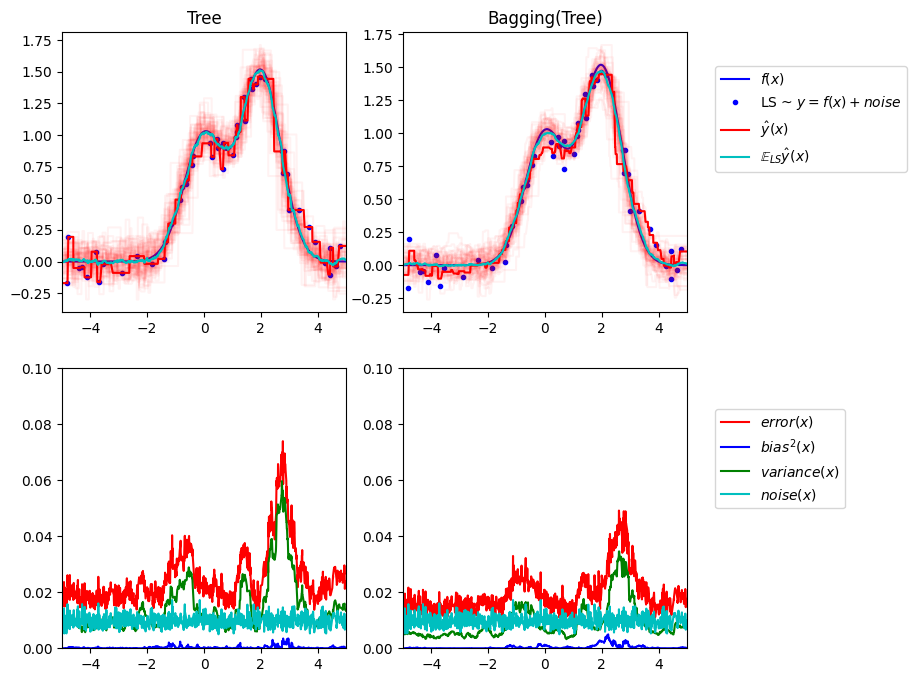

In [1]:
import numpy as np #
import matplotlib.pyplot as plt #

from sklearn.ensemble import BaggingRegressor # беггинг
from sklearn.tree import DecisionTreeRegressor # дерево для регрессии

# Установки
n_repeat = 50       # Число итераций для генерации шума
n_train = 50        # число примеров обучения
n_test = 1000       # число примеров теста
noise = 0.1         # дисперсия (стандартное отклонение) шума
np.random.seed(0) # начало генератора случайных чисел

# проверяемые модели, дерево и ансамбль деревьев
# по умолчанию в ансамбле будет 10 деревьев.
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)",
               BaggingRegressor(DecisionTreeRegressor(),
                                n_estimators=10,max_samples=1.0))]

# число проверяемых моделей
n_estimators = len(estimators)

# Функция для генерации данных
def f(x):
    x = x.ravel() #
    # пример красивой функции
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

# функция для генерации и добавления шума в данные
def generate(n_samples, noise, n_repeat=1):
    # n_samples - число примеров,
    # noise - дисперсия шума
    # n_repeat - число повторов

    # входы в функцию - абциссы по оси OX, случайно выбранные
    X = np.random.rand(n_samples) * 10 - 5 # некоторые случайные числа от -5 до 5
    X = np.sort(X) # отсортированы

    # Выходы функции
    if n_repeat == 1: # если повтор один
        # добавляем шум - случайные числа с нормальным распределением, с нулевым средним, с заданной дисперсией noise
        y = f(X) + np.random.normal(0.0, noise, n_samples) #
    else:
        y = np.zeros((n_samples, n_repeat)) # иначе сначала забиваем нулями

        for i in range(n_repeat): # а потом в цикле по количеству повторов
            # делаем несколько зашумленных функций
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1)) # отформатируем входы в этом виде

    return X, y # возвратим входы и выходы функции с шумом


X_train = [] # место под обучающие входы
y_train = [] # место под обучающие выходы

for i in range(n_repeat): # в цикле по количеству повторов
    X, y = generate(n_samples=n_train, noise=noise) # генерируем данные с шумом
    X_train.append(X) # добавляем их ко входам
    y_train.append(y) # и выходам
# то же для теста
X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8)) # полотно для рисования

# В цикле по количеству моделей
for n, (name, estimator) in enumerate(estimators): #
    # вычисляем выходы
    y_predict = np.zeros((n_test, n_repeat)) # место под выходы
    #
    for i in range(n_repeat): # в цикле по количеству повторов
        estimator.fit(X_train[i], y_train[i]) # обучаем модель на своих данных
        y_predict[:, i] = estimator.predict(X_test) # считаем выход модели

    # Bias^2 + Variance + Noise вычисляем составляющие ошибки
    y_error = np.zeros(n_test) # место под результаты теста

    # средняя ошибка
    for i in range(n_repeat): # в цикле по количеству повторов
        for j in range(n_repeat): # еще раз в цикле по количеству повторов
            # находим сумму квадратов разности истинного и расчитанного выхода для всех комбинаций
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat) # делим на количество комбинаций - получаем среднее

    y_noise = np.var(y_test, axis=1) # часть ошибки от шума (дисперсия).
    # Примечание: т.к. дисперсия считается для отклонения от среднего значения, то нам не надо самим искать это среднее
    # axis=1 показывает что мы ищем по дисперсию по повторам, а не по примерам.
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2 # часть ошибки от смещения - квадрат отклонения среднего от истинного значений
    y_var = np.var(y_predict, axis=1) # часть ошибки от дисперсии результатов
    # выводим эти числа на экран
    print("{0:13.15}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Рисуем картинки
    plt.subplot(2, n_estimators, n + 1) # свои подграфики каждой модели
    plt.plot(X_test, f(X_test), "b", label="$f(x)$") # истинная функция
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$") # обучающие точки
    #
    for i in range(n_repeat): # в цикле по количеству повторов
        if i == 0: # если это первый повтор рисуем результаты
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else: # другие повторы рисуем полупрозрачным цветом
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    # рисуем среднее значение
    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5]) # область просмотра графика
    plt.title(name) # название графика

    # легенда графика на последней итерации
    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5)) #
    # на других подграфиках рисуем:
    plt.subplot(2, n_estimators, n_estimators + n + 1) #
    plt.plot(X_test, y_error, "r", label="$error(x)$") # ошибку модели
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"), # квадрат смещения ошибки модели
    plt.plot(X_test, y_var, "g", label="$variance(x)$"), # дисперсию ошибки модели
    plt.plot(X_test, y_noise, "c", label="$noise(x)$") # дисперсию шума модели
    #
    plt.xlim([-5, 5]) #  область просмотра графика по Х
    plt.ylim([0, 0.1]) # область просмотра графика по У

    if n == n_estimators - 1: # легенда
        plt.legend(loc=(1.1, .5)) #

plt.subplots_adjust(right=.75) # немного сожмем графики настроив правую границу их, чтобы лучше смотрелось
plt.show() # отображаем графики

Верхние рисунки показывают темно-красным цветом результаты моделей (одного дерева решений слева и ансамбля деревьев справа), а светло-красным -  других реализации моделей, обученных на своем, случайно сгенерированном наборе примеров.

Визуально дисперсия результатов это  ширина красной полосы. Чем больше дисперсия, тем более чувствительны результаты к небольшим изменениям в обучающем наборе.

Визуально смещение результатов это разница между средним значением результата (голубой цвет) и истинной функцией (синий  цвет).

Видим, что смещение довольно мало (и голубая, и синяя кривые находятся близко друг к другу), а дисперсия велика (красная полоса довольно широка).

На нижних рисунках показаны ошибка и ее составляющие для наших моделей. По числам и графикам видим, что дисперсия результатов ансамбля деревьев меньше, чем у одиночного дерева, а смещения и шум практически одинаковы, хотя смещение у ансамбля чуть-чуть выше.

Общая ошибка ансамбля оказалась меньше, чем общая ошибка одного дерева, и эта разница в основном проистекает именно из-за уменьшенной дисперсии.

Попробуйте изменять число деревьев в ансамбле и количество примеров для их обучения и посмотрите, как это влияет на результат.

Надо запомнить, что беггинг хорошо применим только при некоррелированности ошибок, т.е. если они независимы, что не всегда выполняется. Если ошибки связаны, то результаты будут гораздо хуже.

Пробуйте по аналогии сделать беггинг ансамбли с другими известными вам моделями.


## Разделяющая поверхность
Подумайте минутку, а какая будет форма разделяющей поверхности, если мы будем решать задачу классификации с помощью беггинга деревьев?

Запустите код ниже, посмотрите на результат и объясните его, сравните с разделяющей поверхностью для одного дерева.

Попробуйте для беггинга других известных вам классификаторов.

In [2]:
# Классификация с шумом

# функция для рисования разделяющей поверхности на плоскости

# Div_plate(clf,flip_level) принимает объект-классификатор и уровень шума (ошибок)
# создает двумерные данные, обучает классификатор, рисует разделяющую поверхность

def Div_plate(clf, flip_level):
    from sklearn.datasets import make_classification # для генерации данных
    from sklearn.model_selection import train_test_split # для разделения на обучение и тест
    import numpy as np
    import seaborn as sns # для простого отображения
    import matplotlib.pyplot as plt #
    # создаем данные
    X,y = make_classification(n_samples=10000, # число примеров
                              n_features=2, # число признаков (атрибутов)
                              n_informative=2, # из них информативных
                              n_redundant=0, # из них не информативных
                              n_repeated=0, # из них повторяющихся
                              n_classes=2, # число классов
                              n_clusters_per_class=1, # число кластеров на класс
                              class_sep=2, # влияет на расстояние между кластерами
                              flip_y=flip_level, # доля ошибок (шума)
                              weights=[0.5,0.5], # пропорции числа данных в классах
                              random_state=17) #

    # разделяем на обучающие и тестовые, случайно
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    # рисуем данные
    plt.subplots();#
    ax1=plt.gca();#
    sns.scatterplot(x=X_train[:,0],y=X_train[:,1],hue=y_train,ax=ax1);# обучающие
    sns.scatterplot(x=X_test[:,0],y=X_test[:,1],hue=y_test,ax=ax1,marker="+");# тестовые
    ax1.set_title("Data With Noise");#
    plt.show();#
    # Создаем классификатор на основе ансамбля. Изменяйте параметры и смотрите как это влияет на обучение
    clf.fit(X_train, y_train) # обучаем
    y_pred = clf.predict(X_test) # проверяем на тесттовых данных
    score=clf.score(X_test, y_test) # считаем среднюю точность
    print('Score=',score)
    ind=y_test==y_pred; # индексы совпадений результата классификации и меток классов
    plt.subplots();
    ax2=plt.gca();
    # рисуем "правильно" распознанные примеры
    sns.scatterplot(x=X_test[ind,0],y=X_test[ind,1],hue=y_test[ind],ax=ax2);
    # рисуем "неправильно" распознанные примеры
    sns.scatterplot(x=X_test[~ind,0],y=X_test[~ind,1],hue=y_pred[~ind],ax=ax2,marker="+");

    ax2.set_title("With Noise");
    # считаем и рисуем разделяющую поверхность.
    plot_step=0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # немного измененные минимальное и максимальые значения превого атрибута
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # немного измененные минимальное и максимальые значения второго атрибута
    # считаем прямоугольную сетку возможных значений этих атрибутов
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), #
                         np.arange(y_min, y_max, plot_step)) #
    # считаем выход классификатора для всех примеров сетки
    # не забыв что массивы данных нужно привести к требуемому размеру.
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape) # и преобразуем обратно в исходному размеру
    # рисуем разделяющую поверхность
    cs = plt.contourf(xx, yy, Z, levels=1, colors=['blue','orange'],alpha=0.3) # рисуем контурную карту
    plt.show();

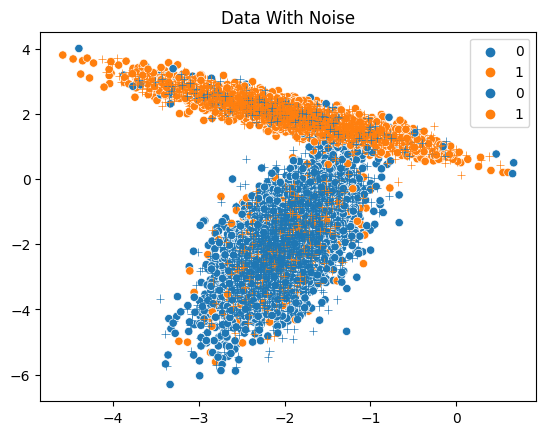

Score= 0.883030303030303


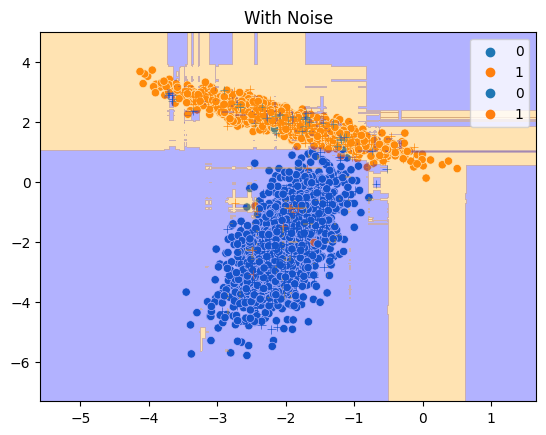

In [ ]:
from sklearn.ensemble import   BaggingClassifier #
from sklearn.tree import DecisionTreeClassifier # дерево для регрессии
clf=BaggingClassifier(DecisionTreeClassifier(), n_estimators=10,max_samples=0.5)
flip_level=0.2
Div_plate(clf,flip_level)

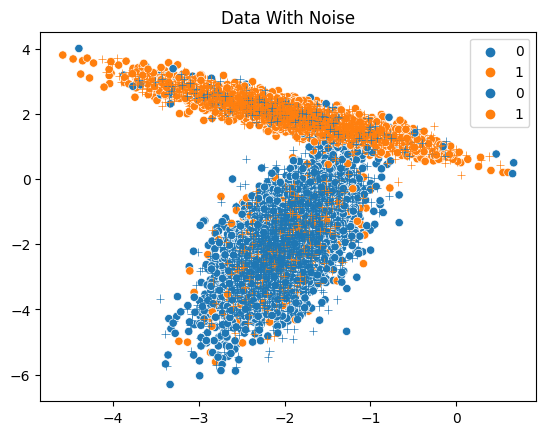

Score= 0.8827272727272727


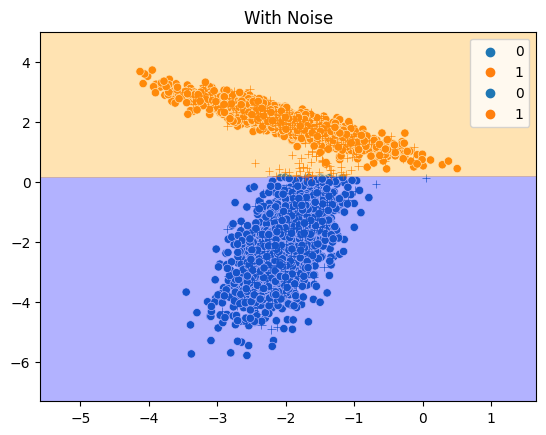

In [3]:
from sklearn.ensemble import   BaggingClassifier #
from sklearn.linear_model import LogisticRegression # модель для регрессии
#from sklearn.linear_model import LinearRegression # модель для регрессии
clf=BaggingClassifier(LogisticRegression(), n_estimators=10,max_samples=0.5, max_features=0.5)
#clf=BaggingClassifier(LinearRegression(), n_estimators=10,max_samples=0.5, max_features=0.5)
flip_level=0.2
Div_plate(clf,flip_level)

In [4]:
clf.estimators_[0]

LogisticRegression(random_state=733190201)